# Machine Learning Exercises \#1
## James McKee

In [1]:
#imports
import math
import time
import numpy as np
import sklearn
from sklearn import tree
import matplotlib.pyplot as plt
import pandas as pd

## 1. Decision Tree Classifier

### Decison Tree from scratch

In [2]:
#load in data.csv
pd.options.display.max_rows = 200
dataFull = pd.read_csv("data.csv")
print(dataFull.head())
print(dataFull.sort_values(by='class'))

   feature1  feature2  feature3  feature4  class
0       5.0       3.5       1.3       0.3      0
1       6.9       3.1       4.9       1.5      1
2       5.8       2.6       4.0       1.2      1
3       6.7       3.0       5.2       2.3      2
4       5.1       3.3       1.7       0.5      0
     feature1  feature2  feature3  feature4  class
0         5.0       3.5       1.3       0.3      0
93        4.8       3.1       1.6       0.2      0
92        5.1       3.8       1.5       0.3      0
86        5.1       3.5       1.4       0.3      0
81        5.0       3.5       1.6       0.6      0
80        4.9       3.1       1.5       0.1      0
148       5.1       3.5       1.4       0.2      0
95        4.8       3.4       1.6       0.2      0
72        4.9       3.0       1.4       0.2      0
67        5.2       3.5       1.5       0.2      0
59        4.6       3.6       1.0       0.2      0
57        4.7       3.2       1.3       0.2      0
53        4.5       2.3       1.3       0.3

In [3]:
#decision tree

numClasses = len(dataFull['class'].unique())
X = dataFull[['feature1', 'feature2', 'feature3', 'feature4']].to_numpy()
numFeatures = np.shape(X)[1]
Y = dataFull[['class']].to_numpy()

#probability calculation, 'P' = probability
def P(labels, classID):
    count = 0
    for i in range(len(labels)):
        if labels[i] == classID:
            count += 1
    if len(labels) == 0:
        return 0
    else:
        return count / len(labels)

#entropy calculation, H is a common letter representing entropy
def H(data, labels):
    entropy = 0
    for i in range(numClasses):
        p = P(labels, i)
        if p == 0:
            entropy += 0
        else:
            entropy += p * math.log(p, 2)
    return -1 * entropy

def IG(data, labels, feature):
    #try 4 splits, that is 4 intermediate values between the minimum value of a feature and its maximum
    #these split the feature into everything equal or less than the split and everything greater than it
    #otherwise we'd have to do a large multiway split or arbitrarily pick a dividing line, (in lieu of some better method)
    splitCount = 4

    minVal = min([row[feature] for row in data])
    maxVal = max([row[feature] for row in data])
    
    interval = (maxVal - minVal)/(splitCount + 1)#try numerous values between min and max
    bestSplit = -1
    bestVal = -1000000
    
    for i in range(splitCount):
        split = minVal + interval * (i + 1)
        #try split
        belowData = []
        belowLabels = []
        aboveData = []
        aboveLabels = []
        for j in range(len(data)):
            if data[j][feature] <= split:
                belowData.append(data[j][:])
                belowLabels.append(labels[j])
            else:
                aboveData.append(data[j][:])
                aboveLabels.append(labels[j])
        
        #get coefficients
        numTotal = len(data)
        numBelow = len(belowData)
        numAbove = len(aboveData)

        #separate values mostly for debug
        a = H(data, labels)
        b = (numBelow / numTotal) * H(belowData, belowLabels)
        c = (numAbove / numTotal) * H(aboveData, aboveLabels)

        #sum
        IG = a - b - c
        #if best, overwrite previous best
        if IG > bestVal:
            bestVal = IG
            bestSplit = split
    
    return bestSplit, bestVal

def split(feature, splitValue, data, labels):
    #like above, but this time we keep it
    belowData = []
    belowLabels = []
    aboveData = []
    aboveLabels = []

    #split
    for i in range(len(data)):
        if data[i][feature] <= splitValue:
            belowData.append(data[i][:])
            belowLabels.append(labels[i])
        else:
            aboveData.append(data[i][:])
            aboveLabels.append(labels[i])
            
    return belowData, aboveData, belowLabels, aboveLabels

def buildDecisionTree(data,labels,maxDepth):
    #going to build a binary tree, 0 -> 1,2 ; 1 -> 3,4 ; 2 -> 5,6 ; 3 -> 7,8 ; x -> 2x+1, 2x+2
    tree = [] #one item in tree consists of [feature, splitvalue, class = None]
    queue = []
    queue.append([data,labels])
    
    it = 1
    #keep going until we hit maxDepth or queue is empty (later revisions make this impossible, but w/e)
    while queue and it <= 2**maxDepth:
        #print('Iteration: ' + str(it))
        #print(queue[0][1])
        #find split for data at top of queue
        
        #if top of queue is empty, do nothing, but add queue items and tree item to maintain binary nature of tree
        if not queue[0][0] and not queue[0][1]:
            tree.append([None,None,None,None])
            queue.pop(0)
            queue.append([[],[]])
            queue.append([[],[]])
            it += 1
            continue
        classID = queue[0][1][0]

        #we want to stop a branch if an overwhelming number of elements belong to the same class
        #so if 95% of a groups elements are in a single class, we stop splitting there
        endBranch = False
        outlierCount = [0,0,0]
        for i in range(len(queue[0][1])):
            outlierCount[queue[0][1][i]] += 1
        if outlierCount[0]/len(queue[0][1]) > 0.95 or outlierCount[1]/len(queue[0][1]) > 0.95\
        or outlierCount[2]/len(queue[0][1]) > 0.95:
            endBranch = True
        
        #print(endBranch)
        #conditional to avoid trying to split an empty array
        if not endBranch:
            bestIG = 0
            bestFeature = -1
            bestSplitVal = 0
            for i in range(numFeatures):
                splitVal, infoGain = IG(queue[0][0], queue[0][1], i)
                if infoGain > bestIG:
                    bestIG = infoGain
                    bestFeature = i
                    bestSplitVal = splitVal

            bD, aD, bL, aL = split(bestFeature, bestSplitVal, queue[0][0], queue[0][1])
        else:
            bD = []
            aD = []
            bL = []
            aL = []        
        
        #update queue and tree
        if not endBranch:
            queue.append([bD,bL])
            queue.append([aD,aL])
            tree.append([bestFeature, bestSplitVal, round(sum(queue[0][1])/len(queue[0][1]),2), len(queue[0][0])])
        else:
            queue.append([bD,bL])
            queue.append([aD,aL])
            tree.append([None,None,round(sum(queue[0][1])/len(queue[0][1]),2),len(queue[0][0])])
        queue.pop(0)
        
        it += 1
    #split over feature with best IG, according to best found split
    #repeat to max depth
    
    return tree

def predictClass(decTree,datum):
    currInd = 0
    while True:
        if decTree[currInd][0] != None:
            if datum[decTree[currInd][0]] <= decTree[currInd][1]:
                if (currInd * 2 + 1) < len(decTree):
                    currInd = currInd * 2 + 1
                else:
                    return round(decTree[currInd][2])
            else:
                if (currInd * 2 + 2) < len(decTree):
                    currInd = currInd * 2 + 2
                else:
                    return round(decTree[currInd][2])
        else:
            return round(decTree[currInd][2])

def testDecisionTree(testData, testLabels, decTree):
    #for each data point in the testset, follow splits, get prediction
    testNum = len(testData)
    classPreds = []
    for i in range(testNum):
        classPred = predictClass(decTree,testData[i])
        classPreds.append(classPred)
        
    #count correct predictions,
    correct = 0
    for i in range(testNum):
        if classPreds[i] == testLabels[i]:
            correct += 1
    #return %correct predictions
    return correct/testNum

In [4]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(X, Y, test_size=0.20)

#flatten labels
ytrain = [label for sub in ytrain for label in sub]
Xtrain = [features for features in Xtrain.tolist()]

decTree = buildDecisionTree(Xtrain, ytrain, 4)
print('Tree')
print('Key: [Split Feature, Split Value, Average Class, Number of Elements]' )
print("If the first two values are 'None', then this is a leaf node.")
print("Just 'None' means the tree did not continue to this point.")
print('')
it = 0
for i in range(int(math.log(len(decTree),2))):
    stringHolder = []
    for j in range(2**i):
        if str(decTree[it]) == '[None, None, None, None]':
            stringHolder.append(str(['None']))
        else:
            stringHolder.append(str(decTree[it]))
        it += 1
    string = ', '.join(stringHolder)
    string = string.center(100)
    print(string)
    print(('...').center(100))
    
print('Accuracy: ' + str(testDecisionTree(Xtest, ytest, decTree)))

Tree
Key: [Split Feature, Split Value, Average Class, Number of Elements]
If the first two values are 'None', then this is a leaf node.
Just 'None' means the tree did not continue to this point.

                                        [2, 2.14, 1.0, 120]                                         
                                                ...                                                 
                             [None, None, 0.0, 39], [3, 1.6, 1.48, 81]                              
                                                ...                                                 
           ['None'], ['None'], [None, None, 1.05, 42], [3, 1.8599999999999999, 1.95, 39]            
                                                ...                                                 
['None'], ['None'], ['None'], ['None'], ['None'], ['None'], [1, 2.92, 1.82, 11], [None, None, 2.0, 28]
                                                ...                                            

### 2 Decision Tree using Sklearn Library

Use the Decision Tree Classifier from the Sklearn Library and use gini index as a splitting measure. Use the data.csv dataset.
Calculate accuracy for this model. 
Print the Decision tree and compare the Decision Trees generated from your code and Sklearn.

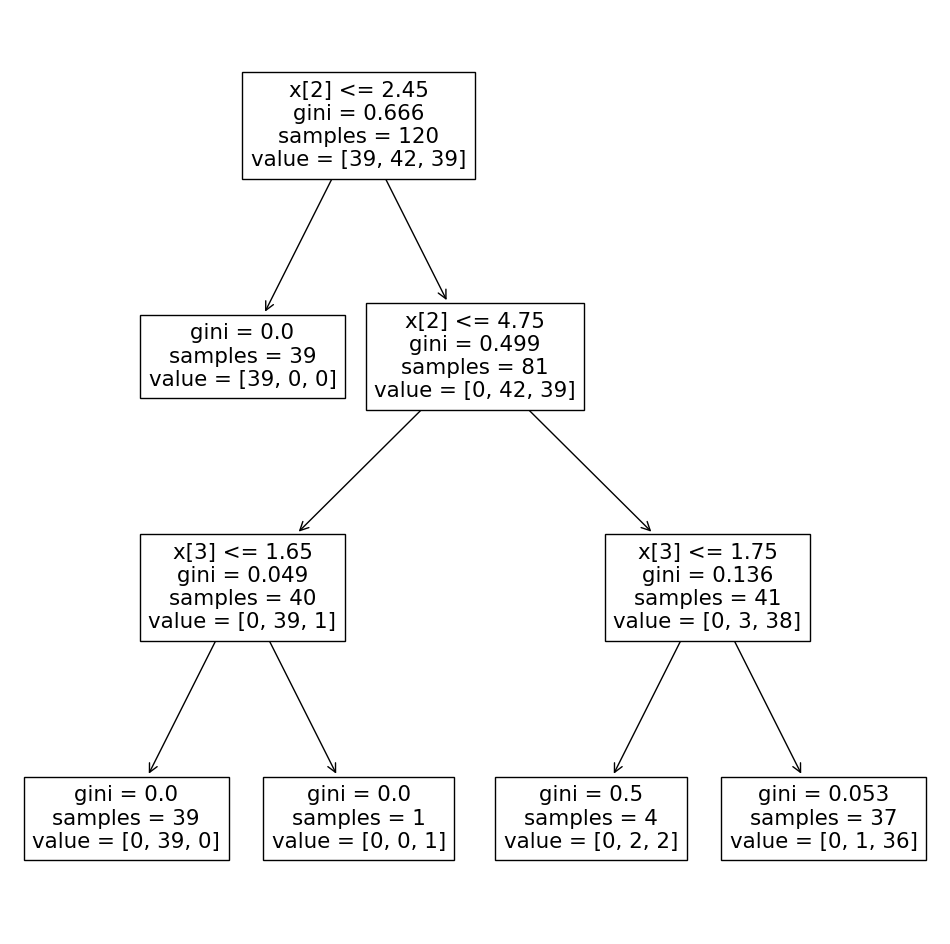

In [5]:
DTC = tree.DecisionTreeClassifier(criterion = 'gini', splitter = 'best', max_depth = 3)
DTC.fit(Xtrain,ytrain)
plt.figure(figsize = (12,12))
tree.plot_tree(DTC)
plt.show()

### 3 Linear Regression

Linear regression attempts to model the relationship between two variables by fitting a linear equation to observed data. One variable is considered to be an explanatory variable, and the other is considered to be a dependent variable. 
<br>


## Gradient descent algorithm 
\begin{equation}
\theta^{+} = \theta^{-} + \frac{\alpha}{m} (y_{i} - h(x_{i}) )\bar{x}
\end{equation}

This minimizes the following cost function

\begin{equation}
J(x, \theta, y) = \frac{1}{2m}\sum_{i=1}^{m}(h(x_i) - y_i)^2
\end{equation}

where
\begin{equation}
h(x_i) = \theta^T \bar{x}
\end{equation}

In [6]:
true_slope = 15
true_intercept = 2.4
input_var = np.arange(0.0,100.0)
output_var = true_slope * input_var + true_intercept + 300.0 * np.random.rand(len(input_var))

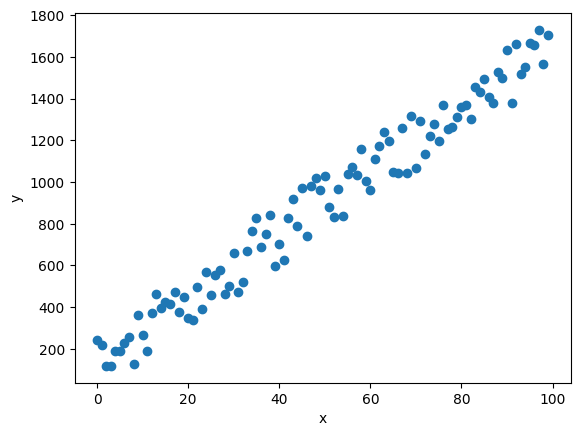

In [7]:
# Do not change the code in this cell
plt.figure()
plt.scatter(input_var, output_var)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [8]:
def compute_cost(ip, op, params):
    """
    Cost function in linear regression where the cost is calculated
    ip: input variables
    op: output variables
    params: corresponding parameters
    Returns cost
    """
    num_samples = len(ip)
    cost_sum = 0.0
    for x,y in zip(ip, op):
        y_hat = np.dot(params, np.array([1.0, x]))
        cost_sum += (y_hat - y) ** 2
    
    cost = cost_sum / (num_samples)
    
    return cost

### 4 Implement Linear Regression using Batch Gradient Descent from scratch 


### Batch gradient descent
Algorithm can be given as follows:

```for j in 0 -> max_iteration: 
    for i in 0 -> m: 
        theta += (alpha / m) * (y[i] - h(x[i])) * x_bar
```

In [9]:
def linear_regression_using_batch_gradient_descent(ip, op, params, alpha, max_iter):
    """
    Compute the params for linear regression using batch gradient descent
    ip: input variables
    op: output variables
    params: corresponding parameters
    alpha: learning rate
    max_iter: maximum number of iterations
    Returns parameters, cost, params_store
    """ 
    # initialize iteration, number of samples, cost and parameter array
    iteration = 0
    num_samples = len(ip)
    cost = np.zeros(max_iter)
    params_store = np.zeros([2, max_iter])

    # Compute the cost and store the params for the corresponding cost
    while iteration < max_iter:
        cost[iteration] = compute_cost(ip, op, params)
        params_store[:, iteration] = params
        
        print('--------------------------')
        print(f'iteration: {iteration}')
        print(f'cost: {cost[iteration]}')
        print(f'params: {params}')
        
        # Apply batch gradient descent
        #assuming x_bar is just [1,x[i]] like in the cost function, to make dimensions work
        #params += (alpha/len(ip))*(yi-(params@[1,xi]))*[1,xi]
        for i in range(num_samples):
            coeff = (alpha / num_samples) * (op[i] - np.dot(params, [1, ip[i]]))
            params += [coeff, coeff * ip[i]]
        
        iteration += 1
    
    return params, cost, params_store

In [10]:
# Training the model
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(input_var, output_var, test_size=0.20)

params_0 = np.array([20.0, 80.0])

alpha_batch = 1e-3
max_iter = 100
t = time.time()
params_hat_batch, cost_batch, params_store_batch =\
    linear_regression_using_batch_gradient_descent(x_train, y_train, params_0, alpha_batch, max_iter)
print('Time elapsed: ' + str(time.time()-t))

--------------------------
iteration: 0
cost: 13415392.612684093
params: [20. 80.]
--------------------------
iteration: 1
cost: 23238.94747783473
params: [19.08177929 19.0329749 ]
--------------------------
iteration: 2
cost: 10682.378114986861
params: [19.0809659  17.23050045]
--------------------------
iteration: 3
cost: 10644.692510958479
params: [19.10726325 17.17682729]
--------------------------
iteration: 4
cost: 10642.456648718175
params: [19.13435575 17.17484575]
--------------------------
iteration: 5
cost: 10640.976966868222
params: [19.16146554 17.17439221]
--------------------------
iteration: 6
cost: 10639.520049842416
params: [19.18856964 17.17398394]
--------------------------
iteration: 7
cost: 10638.064473881703
params: [19.21566736 17.17357709]
--------------------------
iteration: 8
cost: 10636.609605640306
params: [19.2427587  17.17317039]
--------------------------
iteration: 9
cost: 10635.155426082138
params: [19.26984364 17.17276377]
--------------------------


### 5 Implement Stochastic Gradient Descent from scratch

### Stochastic Gradient Descent
Algorithm can be given as follows:
```shuffle(x, y)
for i in 0 -> m:
    theta += (alpha / m) * (y[i] - h(x[i])) * x_bar  
```

In [11]:
def lin_reg_stoch_gradient_descent(ip, op, params, alpha):
    """
    Compute the params for linear regression using stochastic gradient descent
    ip: input variables
    op: output variables
    params: corresponding parameters
    alpha: learning rate
    Returns parameters, cost, params_store
    """
    
    # initialize iteration, number of samples, cost and parameter array
    num_samples = len(input_var)
    cost = np.zeros(num_samples)
    params_store = np.zeros([2, num_samples])
    
    i = 0
    # Compute the cost and store the params for the corresponding cost
    for x,y in zip(input_var, output_var):
        cost[i] = compute_cost(input_var, output_var, params)
        params_store[:, i] = params
        
        print('--------------------------')
        print(f'iteration: {i}')
        print(f'cost: {cost[i]}')
        
        # Apply stochastic gradient descent
        coeff = (alpha / num_samples) * (y - np.dot(params, [1, x]))
        params += [coeff, coeff * x]
        
        i += 1
    
    return params, cost, params_store

In [12]:
alpha = 1e-3
params_0 = np.array([20.0, 80.0])
t = time.time()
params_hat, cost, params_store =\
lin_reg_stoch_gradient_descent(x_train, y_train, params_0, alpha)
print('Time elapsed: ' + str(time.time()-t))

--------------------------
iteration: 0
cost: 12987763.327227442
--------------------------
iteration: 1
cost: 12987777.030761264
--------------------------
iteration: 2
cost: 12988265.166333614
--------------------------
iteration: 3
cost: 12987765.34714054
--------------------------
iteration: 4
cost: 12986003.144465107
--------------------------
iteration: 5
cost: 12983539.114098888
--------------------------
iteration: 6
cost: 12978827.776162924
--------------------------
iteration: 7
cost: 12972065.441270553
--------------------------
iteration: 8
cost: 12962670.428047946
--------------------------
iteration: 9
cost: 12945051.213333495
--------------------------
iteration: 10
cost: 12931106.549285745
--------------------------
iteration: 11
cost: 12908377.287816763
--------------------------
iteration: 12
cost: 12876272.982026605
--------------------------
iteration: 13
cost: 12846314.37303932
--------------------------
iteration: 14
cost: 12814661.10400246
-----------------------

### 6 Calculate Root Mean Square error in batch gradient descent algorithm and stochastic gradient descent algorithm

In [13]:
# Calculate Root Mean Square error in batch gradient descent algorithm and stochastic gradient descent algorithm
# per Wikipedia, RMSE = sqrt(sum((Ypred-Ytrue)^2)/numData)
batchRMSE = 0
stochRMSE = 0

for i in range(len(input_var)):

    batchRMSE += (np.dot(params_hat_batch, [1, input_var[i]]) - output_var[i]) ** 2
    stochRMSE += (np.dot(params_hat, [1, input_var[i]]) - output_var[i]) ** 2

batchRMSE = (batchRMSE / len(input_var)) ** 0.5
stochRMSE = (stochRMSE / len(input_var)) ** 0.5

print("Batch Gradient Descent Root Mean Square Error: " + str(batchRMSE))
print("Stochastic Gradient Descent Root Mean Square Error: " + str(stochRMSE))

Batch Gradient Descent Root Mean Square Error: 103.23351311484963
Stochastic Gradient Descent Root Mean Square Error: 146.36653335401923


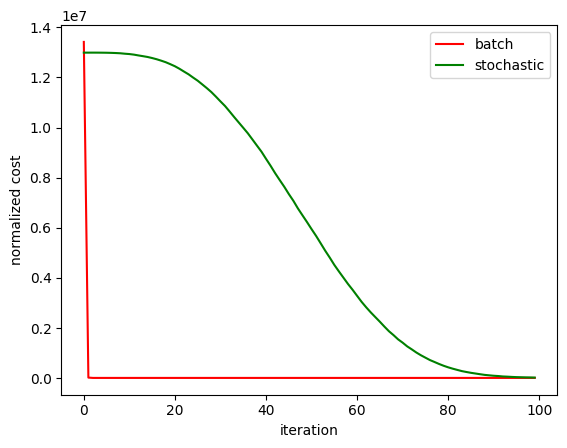

min cost with BGD: 10507.056700281446
min cost with SGD: 24051.23616994097


In [14]:
plt.figure()
plt.plot(np.arange(max_iter), cost_batch, 'r', label='batch')
plt.plot(np.arange(len(cost)), cost, 'g', label='stochastic')
plt.xlabel('iteration')
plt.ylabel('normalized cost')
plt.legend()
plt.show()
print(f'min cost with BGD: {np.min(cost_batch)}')
print(f'min cost with SGD: {np.min(cost)}')

### 7 Which linear regression model do you think works best for this data? Explain in brief

For this data, the Batch model clearly worked better, achieving a lower cost and error than the Stochastic model. That said, a lot of the Batch model's computation was wasted. It seemed to get to where it was going within 3 iterations. Meanwhile, it took Batch over twice as long to finish as the Stochastic model, so perhaps if the Stochastic model had been allowed to train just a little more (say on duplicated data) it probably would have achieved similar results while still taking like half the time.

### 8 Linear Regression Analytical Problem
Consider the following training data.

| X1 | X2 | Y |
| -- | -- | -- |
| 0 | 0 | 0 |
| 0 | 1 | 1.5 |
| 1 | 0 | 2 |
| 1 | 1 | 2.5 |
Suppose the data comes from a model y = $θ_{0}$ +$θ_{1}$x1 +$θ_{2}$x2 for unknown constants $θ_{0}$,$θ_{1}$,$θ_{2}$. Use least squares linear regression to find an estimate of $θ_{0}$,$θ_{1}$,$θ_{2}$.

In [15]:
from sklearn.linear_model import LinearRegression 
x = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y = np.array([0, 1.5, 2, 2.5])

#my guess
print(np.matmul(np.linalg.inv(np.dot(x.T, x)),np.dot(x.T, y)))

#sklearn guess
sklearnLR = LinearRegression().fit(x,y)
print(sklearnLR.score(x,y))
print(sklearnLR.coef_)

[1.66666667 1.16666667]
0.9285714285714285
[1.5 1. ]
